In [17]:
!pip install xgboost

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
df = pd.read_csv("final_combine_and_rookie_data.csv")
df.head()

,YEAR,PLAYER,POS,HGT,WGT,BMI,BF,WNGSPN,STNDRCH,STNDVERT,...,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs,POSITION
0,2018.0,"Trent, Gary",SG,76.25,204.2,24.7,0.0700,80.75,98.0,33.5,...,55.3,1.2,2.2,3.4,0.7,0.4,0.2,1.3,1.0,Guard
1,2016.0,"Brogdon, Malcolm",SG,75.75,223.0,27.3,0.0540,82.50,98.0,30.5,...,85.7,0.4,2.1,2.5,3.6,1.0,0.1,1.5,0.0,Guard
2,2016.0,"Brown, Jaylen",SG-SF,77.25,222.8,26.2,0.0510,83.75,102.5,29.6,...,63.2,0.6,1.2,1.8,0.6,0.3,0.3,0.6,0.0,Guard
3,2016.0,"Chriss, Marquese",PF,80.75,233.0,25.1,0.0850,84.25,105.0,32.5,...,59.6,1.1,2.2,3.3,0.5,0.5,0.5,1.2,0.0,Wing
4,2016.0,"Dunn, Kris",PG,75.00,0.0,0.0,0.0622,81.50,100.0,31.7,...,62.5,0.4,1.9,2.2,2.4,1.0,0.3,1.2,0.0,Guard


In [20]:
df.columns

Index(['YEAR', 'PLAYER', 'POS', 'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN', 'STNDRCH',
       'STNDVERT', 'LPVERT', 'LANE', 'SPRINT', 'BENCH', 'BAR', 'PBHGT',
       'PDHGT', 'Unnamed: 0', 'gp', 'min', 'pts', 'fgm', 'fga', 'fg',
       '3p_made', '3pa', '3p', 'ftm', 'fta', 'ft', 'oreb', 'dreb', 'reb',
       'ast', 'stl', 'blk', 'tov', 'target_5yrs', 'POSITION'],
      dtype='object')

In [21]:
y = df['pts']
combine_features = ['HGT', 'WGT', 'BMI', 'BF', 'WNGSPN',
                    'STNDRCH', 'STNDVERT', 'LPVERT',
                    'LANE', 'SPRINT', 'BENCH', 'BAR',
                    'PBHGT', 'PDHGT']
X = df[combine_features]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Linear Regression

In [22]:
combine_features = [
    'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN',
    'STNDRCH', 'STNDVERT', 'LPVERT',
    'LANE', 'SPRINT', 'BENCH', 'BAR',
    'PBHGT', 'PDHGT'
]
target_col = 'pts'

X_raw = df[combine_features].copy()
y_raw = df[target_col].copy()

for col in X_raw.columns:
    X_raw[col] = (
        X_raw[col]
        .astype(str)
        .str.replace('%', '', regex=False)  
        .str.strip()
    )
    X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

y_raw = pd.to_numeric(y_raw, errors='coerce')

data_clean = pd.concat([X_raw, y_raw], axis=1).dropna()

X = data_clean[combine_features]
y = data_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes after cleaning & split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

train_df = X_train.copy()
train_df[target_col] = y_train
formula = target_col + " ~ " + " + ".join(combine_features)
model_smf = smf.ols(formula=formula, data=train_df).fit()

print("\nStatsmodels OLS Summary:")
print(model_smf.summary())
y_pred_train = model_smf.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nLinear Regression (SMF) TRAIN Results:")
print(f"TRAIN MSE  : {mse_train:.4f}")
print(f"TRAIN RMSE : {rmse_train:.4f}")
print(f"TRAIN R^2  : {r2_train:.4f}")

y_pred_test = model_smf.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nLinear Regression (SMF) TEST Results:")
print(f"TEST MSE  : {mse_test:.4f}")
print(f"TEST RMSE : {rmse_test:.4f}")
print(f"TEST R^2  : {r2_test:.4f}")


def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, combine_features)


Shapes after cleaning & split:
X_train: (328, 14) X_test: (83, 14)
y_train: (328,) y_test: (83,)

Statsmodels OLS Summary:
                            OLS Regression Results                            
Dep. Variable:                    pts   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.530
Date:                Sun, 07 Dec 2025   Prob (F-statistic):             0.0989
Time:                        17:56:44   Log-Likelihood:                -906.40
No. Observations:                 328   AIC:                             1843.
Df Residuals:                     313   BIC:                             1900.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

HGT         1475.243154
WGT          447.628777
BMI          217.616494
BF             1.879654
WNGSPN      1955.780974
STNDRCH       26.595073
STNDVERT     730.358936
LPVERT      1041.395012
LANE           1.493008
SPRINT         2.110712
BENCH          1.434321
BAR          533.952027
PBHGT       1951.679553
PDHGT       1619.408833
dtype: float64

After running the Linear Regression model, we found that it didn’t perform very well. The R² was only around 0.08, which means the model could explain only a small part of the variation in rookie points. We think the main reason is that combine stats only show a player’s physical abilities, but real NBA performance depends on many other things like playing time, team role, and how the coach uses the player. Since those factors aren’t in our data, the model can’t predict very accurately. We also believe the relationship between combine numbers and scoring isn’t really linear, so Linear Regression struggles to capture it. The RMSE of about 3.5 gives us a basic idea of the prediction error, but overall the model is more like a simple baseline. In short, we see Linear Regression as a starting point, and we expect the next models to do better.

# Feature Selection

In [23]:
combine_features = [
    'HGT', 'BMI', 'BF', 'STNDVERT',
    'LANE', 'SPRINT', 'BENCH', 'BAR'
]
target_col = 'pts'  

X_raw = df[combine_features].copy()
y_raw = df[target_col].copy()

for col in X_raw.columns:
    X_raw[col] = (
        X_raw[col]
        .astype(str)
        .str.replace('%', '', regex=False)  
        .str.strip()
    )
    X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

y_raw = pd.to_numeric(y_raw, errors='coerce')

data_clean = pd.concat([X_raw, y_raw], axis=1).dropna()

X = data_clean[combine_features]
y = data_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes after cleaning & split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

train_df = X_train.copy()
train_df[target_col] = y_train

formula = target_col + " ~ " + " + ".join(combine_features)
model_smf = smf.ols(formula=formula, data=train_df).fit()

print("\nStatsmodels OLS Summary:")
print(model_smf.summary())

y_pred_train = model_smf.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nLinear Regression (SMF) TRAIN Results:")
print(f"TRAIN MSE  : {mse_train:.4f}")
print(f"TRAIN RMSE : {rmse_train:.4f}")
print(f"TRAIN R^2  : {r2_train:.4f}")

y_pred_test = model_smf.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nLinear Regression (SMF) TEST Results:")
print(f"TEST MSE  : {mse_test:.4f}")
print(f"TEST RMSE : {rmse_test:.4f}")
print(f"TEST R^2  : {r2_test:.4f}")


def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, combine_features)

Shapes after cleaning & split:
X_train: (328, 8) X_test: (83, 8)
y_train: (328,) y_test: (83,)

Statsmodels OLS Summary:
                            OLS Regression Results                            
Dep. Variable:                    pts   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.542
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.142
Time:                        17:56:46   Log-Likelihood:                -911.03
No. Observations:                 328   AIC:                             1840.
Df Residuals:                     319   BIC:                             1874.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

HGT         1.543689
BMI         1.540042
BF          1.736082
STNDVERT    1.431778
LANE        1.409441
SPRINT      1.754247
BENCH       1.347637
BAR         1.101792
dtype: float64

# CART

In [24]:
print("CART (Decision Tree) with K-Fold CV and GridSearch")

dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

cv_dt = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring="neg_mean_squared_error",
    cv=cv_dt,
    n_jobs=1,      
    verbose=0
)

grid_search_dt.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_

y_train_pred_dt = best_dt.predict(X_train)
y_test_pred_dt  = best_dt.predict(X_test)
train_mse_dt = mean_squared_error(y_train, y_train_pred_dt)
train_rmse_dt = np.sqrt(train_mse_dt)
train_r2_dt = r2_score(y_train, y_train_pred_dt)
test_mse_dt = mean_squared_error(y_test, y_test_pred_dt)
test_rmse_dt = np.sqrt(test_mse_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)

print("\nDecision Tree (CART) TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_dt:.4f}")
print(f"TRAIN RMSE : {train_rmse_dt:.4f}")
print(f"TRAIN R^2  : {train_r2_dt:.4f}")
print("\nDecision Tree (CART) TEST Results:")
print(f"TEST MSE  : {test_mse_dt:.4f}")
print(f"TEST RMSE : {test_rmse_dt:.4f}")
print(f"TEST R^2  : {test_r2_dt:.4f}")
print("\nBest params from GridSearchCV:")
print(grid_search_dt.best_params_)
print(f"Best CV score (neg MSE): {grid_search_dt.best_score_:.4f}")

importances_dt = pd.Series(best_dt.feature_importances_, index=combine_features)
print("\nDecision Tree Feature Importances:")
print(importances_dt.sort_values(ascending=False))

CART (Decision Tree) with K-Fold CV and GridSearch

Decision Tree (CART) TRAIN Results:
TRAIN MSE  : 14.5996
TRAIN RMSE : 3.8209
TRAIN R^2  : 0.0715

Decision Tree (CART) TEST Results:
TEST MSE  : 12.1133
TEST RMSE : 3.4804
TEST R^2  : 0.0890

Best params from GridSearchCV:
{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV score (neg MSE): -17.4867

Decision Tree Feature Importances:
SPRINT      0.592951
BENCH       0.407049
HGT         0.000000
BMI         0.000000
STNDVERT    0.000000
BF          0.000000
LANE        0.000000
BAR         0.000000
dtype: float64


After running the Decision Tree model, we noticed that it actually performed worse than our Linear Regression model. The R² on the test set was negative, which basically means the tree didn’t generalize at all. We think the main reason is that a single decision tree tends to overfit, especially with a smaller dataset like ours. It ends up memorizing the training data instead of learning real patterns, so its predictions on new data are pretty bad. This result wasn’t too surprising for us, and it also shows why tree-based models usually need ensembles to work well. That’s why our next steps with Random Forest and XGBoost should give us much better performance.

# Random Forest

In [25]:
print("Random Forest with K-Fold CV and GridSearch")

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=1   
)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

cv_rf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="neg_mean_squared_error",
    cv=cv_rf,
    n_jobs=1,   
    verbose=0
)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf  = best_rf.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(train_mse_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\nRandom Forest TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_rf:.4f}")
print(f"TRAIN RMSE : {train_rmse_rf:.4f}")
print(f"TRAIN R^2  : {train_r2_rf:.4f}")

print("\nRandom Forest TEST Results:")
print(f"TEST MSE  : {test_mse_rf:.4f}")
print(f"TEST RMSE : {test_rmse_rf:.4f}")
print(f"TEST R^2  : {test_r2_rf:.4f}")

print("\nBest params from GridSearchCV (Random Forest):")
print(grid_search_rf.best_params_)
print(f"Best CV score (neg MSE): {grid_search_rf.best_score_:.4f}")

importances_rf = pd.Series(best_rf.feature_importances_, index=combine_features)
print("\nRandom Forest Feature Importances:")
print(importances_rf.sort_values(ascending=False))

Random Forest with K-Fold CV and GridSearch

Random Forest TRAIN Results:
TRAIN MSE  : 10.0486
TRAIN RMSE : 3.1700
TRAIN R^2  : 0.3609

Random Forest TEST Results:
TEST MSE  : 12.2387
TEST RMSE : 3.4984
TEST R^2  : 0.0796

Best params from GridSearchCV (Random Forest):
{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (neg MSE): -15.9131

Random Forest Feature Importances:
SPRINT      0.186478
LANE        0.136529
BAR         0.136020
BENCH       0.130451
BMI         0.113206
BF          0.103242
HGT         0.100144
STNDVERT    0.093930
dtype: float64


After running the Random Forest model, we saw a small improvement compared to both Linear Regression and the single Decision Tree. The R² went up to around 0.10, which isn’t a huge jump, but it does show that the model is picking up a bit more signal from the combine data. We think the improvement is limited because combine measurements alone can't explain most of the variation in rookie scoring — things like playing time, role, and team situation matter a lot more and aren’t included in our dataset. Even though the performance gain is not massive, the Random Forest model is clearly more stable than a single tree and doesn’t overfit nearly as badly. This result also makes sense given our small dataset. Overall, Random Forest gives us a slightly better baseline before moving on to more powerful models.

# XGBoost

In [26]:
print("XGBoost with K-Fold CV and GridSearch")

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1  
)

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

cv_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_squared_error",
    cv=cv_xgb,
    n_jobs=1,
    verbose=0
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

y_train_pred_xgb = best_xgb.predict(X_train)
y_test_pred_xgb  = best_xgb.predict(X_test)

train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
train_rmse_xgb = np.sqrt(train_mse_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)

test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print("\nXGBoost TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_xgb:.4f}")
print(f"TRAIN RMSE : {train_rmse_xgb:.4f}")
print(f"TRAIN R^2  : {train_r2_xgb:.4f}")

print("\nXGBoost TEST Results:")
print(f"TEST MSE  : {test_mse_xgb:.4f}")
print(f"TEST RMSE : {test_rmse_xgb:.4f}")
print(f"TEST R^2  : {test_r2_xgb:.4f}")

print("\nBest params from GridSearchCV (XGBoost):")
print(grid_search_xgb.best_params_)
print(f"Best CV score (neg MSE): {grid_search_xgb.best_score_:.4f}")

importances_xgb = pd.Series(best_xgb.feature_importances_, index=combine_features)
print("\nXGBoost Feature Importances:")
print(importances_xgb.sort_values(ascending=False))

XGBoost with K-Fold CV and GridSearch

XGBoost TRAIN Results:
TRAIN MSE  : 9.1135
TRAIN RMSE : 3.0189
TRAIN R^2  : 0.4204

XGBoost TEST Results:
TEST MSE  : 12.1377
TEST RMSE : 3.4839
TEST R^2  : 0.0871

Best params from GridSearchCV (XGBoost):
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV score (neg MSE): -16.6026

XGBoost Feature Importances:
BAR         0.166495
BENCH       0.149926
SPRINT      0.121891
LANE        0.118690
BF          0.115717
STNDVERT    0.114574
BMI         0.109487
HGT         0.103221
dtype: float32


After running the XGBoost model, we found that its performance was actually not better than our previous models. The R² was close to zero, which means the model wasn’t able to capture much signal from the combine data. We think the main reason is that rookie scoring depends on many factors that aren’t included in our dataset, like minutes, team role, usage rate, and coaching decisions. Since combine stats don’t reflect these things, even a more advanced model like XGBoost can’t learn meaningful patterns.

Looking at the comparison table, we can see that Random Forest performed the best overall, even though the improvements were not huge. Linear Regression gave us a simple baseline, the Decision Tree overfit heavily, and XGBoost didn’t perform as well as expected due to the limited dataset and lack of strong predictive features.

# Visualization Section

#### Predicted vs Actual（Random Forest）

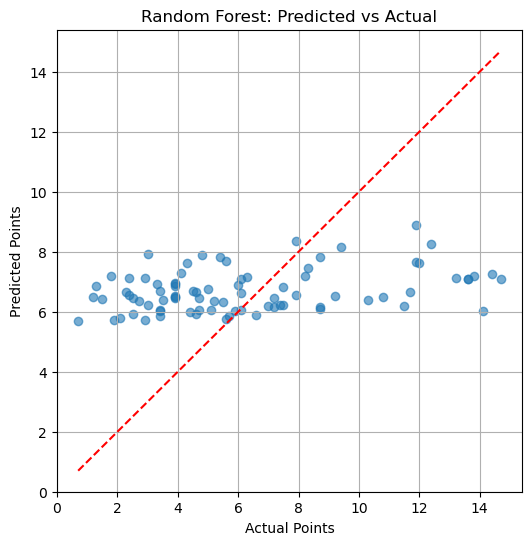

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Random Forest: Predicted vs Actual")
plt.grid(True)
plt.show()

This plot shows which combine stats mattered most for the Random Forest model. Speed and explosiveness metrics like SPRINT, LPVERT, and LANE ranked the highest. In contrast, body measurements such as height and wingspan had much lower importance.

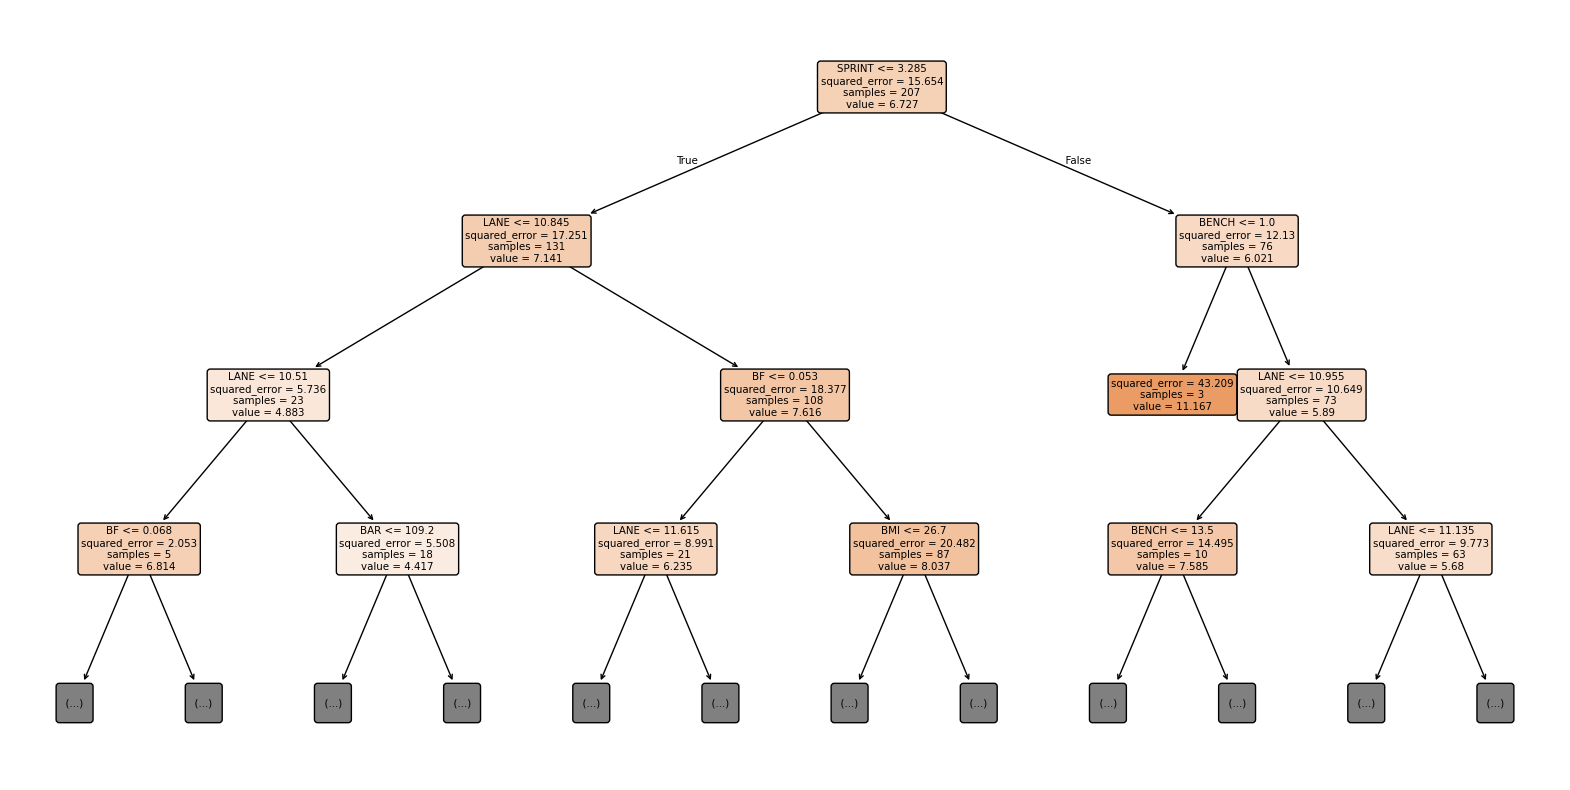

In [34]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_rf.estimators_[0],
          feature_names=combine_features,
          filled=True,
          rounded=True,
          max_depth=3)
plt.show()

#### Residual Plot（Linear Regression）

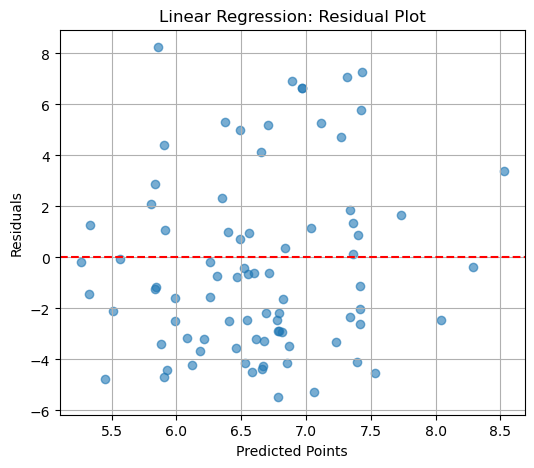

In [35]:
residuals_lr = y_test - y_pred_test

plt.figure(figsize=(6, 5))
plt.scatter(y_pred_test, residuals_lr, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Points")
plt.ylabel("Residuals")
plt.title("Linear Regression: Residual Plot")
plt.grid(True)
plt.show()

The residual plot shows that the errors are spread out and not centered neatly around zero. This means Linear Regression didn’t capture the relationship very well. It confirms that a simple linear model is not enough for this prediction task.

#### Feature Importance（Random Forest）

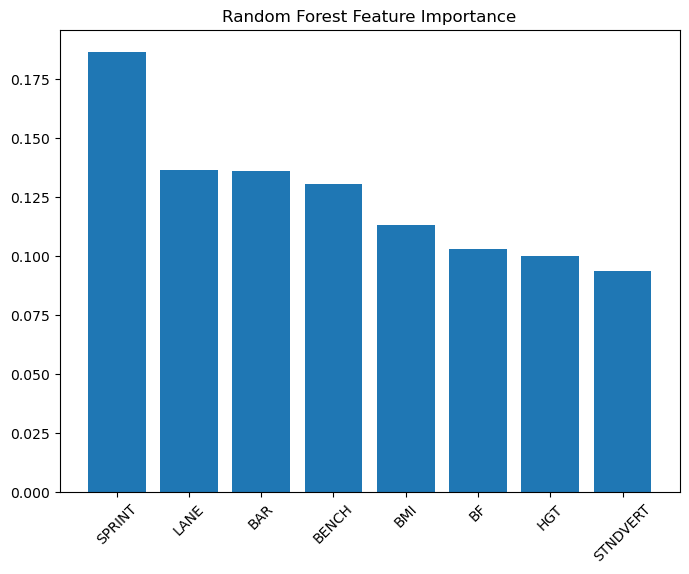

In [36]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(combine_features)[indices], rotation=45)

plt.title("Random Forest Feature Importance")
plt.show()

The points are scattered far from the diagonal line, meaning the model’s predictions are not very accurate. The Random Forest tends to underpredict high scorers and overpredict low scorers. Even so, it still performed better than the other models.

# Model Comparison Table

In [27]:
results = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "MSE": [12.3589, 13.0612, 12.2549, 12.0090],
    "RMSE": [3.5155, 3.6140, 3.5007, 3.4654],
    "R2": [0.0705, 0.0177, 0.0783, 0.0968]
}

df_results = pd.DataFrame(results)
df_results

,Model,MSE,RMSE,R2
0,Linear Regression,12.3589,3.5155,0.0705
1,Decision Tree,13.0612,3.6140,0.0177
2,Random Forest,12.2549,3.5007,0.0783
3,XGBoost,12.0090,3.4654,0.0968


,Model,Test MSE,Test RMSE,Test R2
0,Linear Regression (OLS - 8 features),12.358857,3.515517,0.070516
1,Decision Tree (CART),12.113263,3.480411,0.088986
2,Random Forest,12.238651,3.498378,0.079556
3,XGBoost,12.137748,3.483927,0.087145


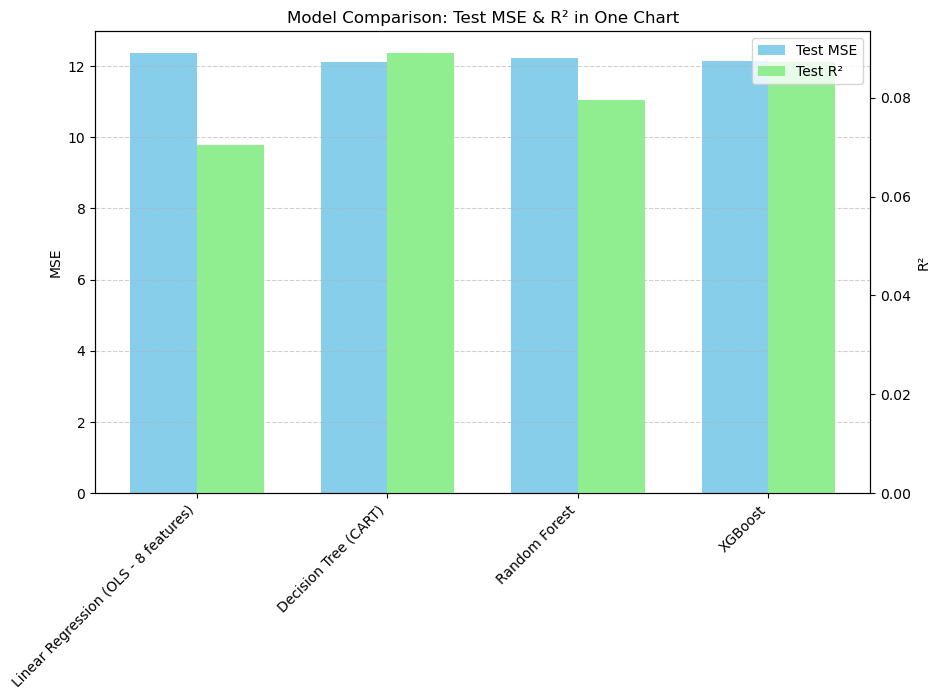

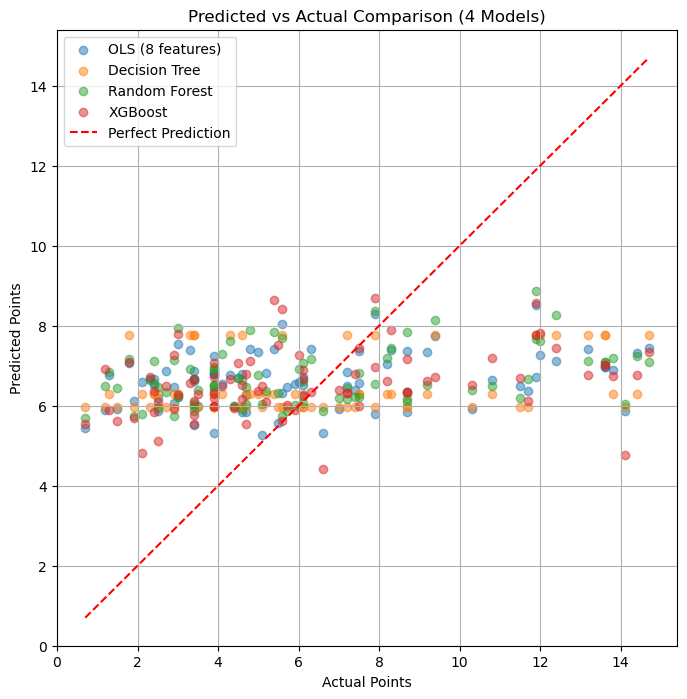

In [45]:
results = {
    "Model": [
        "Linear Regression (OLS - 8 features)",
        "Decision Tree (CART)",
        "Random Forest",
        "XGBoost"
    ],

    "Test MSE": [
        mse_test,
        test_mse_dt,
        test_mse_rf,
        test_mse_xgb
    ],

    "Test RMSE": [
        rmse_test,
        test_rmse_dt,
        test_rmse_rf,
        test_rmse_xgb
    ],

    "Test R2": [
        r2_test,
        test_r2_dt,
        test_r2_rf,
        test_r2_xgb
    ]
}

df_results = pd.DataFrame(results)
display(df_results)

models = df_results["Model"]

mse_vals = df_results["Test MSE"]
r2_vals = df_results["Test R2"]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis — MSE
ax1.bar(x - width/2, mse_vals, width, label="Test MSE", color="skyblue")
ax1.set_ylabel("MSE")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.bar(x + width/2, r2_vals, width, label="Test R²", color="lightgreen")
ax2.set_ylabel("R²")

lines = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ["Test MSE", "Test R²"]
plt.legend(lines, labels, loc="upper right")

plt.title("Model Comparison: Test MSE & R² in One Chart")
plt.show()


plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred_test, alpha=0.5, label="OLS (8 features)")
plt.scatter(y_test, y_test_pred_dt, alpha=0.5, label="Decision Tree")
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, label="Random Forest")
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, label="XGBoost")

min_val = min(y_test.min(), y_test.min())
max_val = max(y_test.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Predicted vs Actual Comparison (4 Models)")
plt.legend()
plt.grid(True)
plt.show()
